# Laplace Approximation: the world from the peak of the mountain

The Laplace method is a powerful technique to approximate the shape of a given function through a Gaussian.
The approximation relies on the Taylor expansion of the (log-)function of interest $f$ that we wish to approximate.
Starting from the simple observation that:

$$ f(x) = \exp(\log(f(\theta)) = \exp(g(\theta)),$$

Let us assume that $g$, and thus $f$, have a maximum in $\theta_0$. For any other point $\theta$ sufficiently close to the maximum, we can now approximate the function from this priviledged point of view, to obtain:

$$g(\theta) = g(\theta_0) + g'(\theta_0)(\theta - \theta_0) + \frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2 + O((\theta - \theta_0)^3),$$

In particular, since $\theta_0$ is the maximum, we obtain:

$$g(\theta) \approx g(\theta_0)  \frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2.$$

Taking the exponential on both sides we have:

$$ f(\theta) = \exp(g(x)) \approx \exp(g(\theta_0))\exp(\frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2). $$

In this last equation we can recognize the typical term of the Gaussian pdf:

$$\exp(\frac{1}{2}g''(\theta_0)(\theta - \theta_0)^2),$$

which reminds us of a Gaussian distribution with mean $\theta_0$, and variance $-\frac{1}{g''(\theta_0)}$. This is telling us that our function can be actually approximated (up to a normalizaing constant) by a Gaussian distribution centered around the maximum, and with variance equal to the inverse of the second derivative (the Hessian).

In practice, when we need to approximate a posterior pdf $f$ that we cannot compute in close form, we may simply find its maximum $\theta_0$, and the Hessian $g''(\theta_0)$, and replace them in the corrisponding Gaussian form.
When evaluating $f$ we therefore obtain:


$$\int_a^b f(\theta) d\theta \approx \exp(g(\theta_0)) \int_a^b \exp(-\frac{1}{2}\frac{(\theta - \theta_0)^2}{-g''(\theta_0)^{-1}}) d\theta$$.

If we call $\Phi(\theta|\theta_0,-\frac{1}{g''(\theta_0)})$, the Gaussian pdf, we finally obtain: 

$$\int_a^b f(\theta) d\theta \approx \exp(g(\theta_0))\sqrt{\frac{2\pi}{-g''(\theta_0)}}\int_a^b \Phi(\theta|\theta_0,-\frac{1}{g''(\theta_0)}) d\theta = \exp(g(\theta_0))\sqrt{\frac{2\pi}{-g''(\theta_0)}} \left(\Phi(a|\theta_0,-\frac{1}{g''(\theta_0)}) -  \Phi(b|\theta_0,-\frac{1}{g''(\theta_0)})\right)$$

It is worth noticing that the Laplace approximation replaces the problem of integrating a function with the problem of maximizing it. In order to compute the Laplace approximation, we have to compute the location of the mode, which is an optimization problem. Often, this problem is faster to solve using function optimizers than integrating the same function would be.



**Example. The Laplace approximation of a Binomial distribution**
We can derive the Laplace approximation for the Binomial distribution by simply applying the steps introduced previously.
The Binomial distribution is:
$$f(\theta|y,N)\approx\theta^y(1-\theta)^{N-y},$$

for which the logarithm follows:

$$\log(f) = y\log(\theta) + (N-y)\log(1-\theta).$$

To compute our approximation, we need to:
- Compute the maximum of the log-distribution. We can do this analytically: we derive with respect to \theta and we solve:
$$\frac{d\log(f)}{d\theta} = \frac{y}{\theta} - \frac{N-y}{1-\theta} = 0 \Longrightarrow \frac{(1-\theta)y - \theta(N-y)}{\theta(1-\theta)} = 0$$.
$$y-\theta y - N\theta + \theta y =0 \Longrightarrow y - N\theta = 0 \Longrightarrow \theta = \frac{y}{N}$$

- Compute the second derivative of the log=distribution with respect to $\theta$:
$$\frac{d^2\log(f)}{d\theta^2} = -\frac{y}{\theta^2} - \frac{N-y}{(1-\theta)^2} $$

At this point the problem is solved: the approximation will be a Gaussian with mean $\mu = \frac{y}{N}$ and variance $\sigma^2 = -(-\frac{N^2}{y} - \frac{N-y}{(1-\frac{y}{N})^2})^{-1}$.

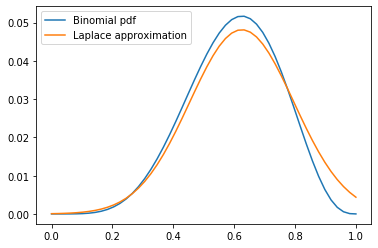

In [34]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Example: Laplace approximation of the Binomial distribution

y = 5
N = 8

theta = np.linspace(0,1)

f = theta**y*(1-theta)**(N-y)

plt.plot(theta,f/np.sum(f), label = 'Binomial pdf')

fmax = y/N

Hessian = -y/fmax**2 - (N-y)/(1-fmax)**2

var = -1/Hessian

Laplace_approx = norm(fmax, np.sqrt(var))

plt.plot(theta, Laplace_approx.pdf(theta)/np.sum(Laplace_approx.pdf(theta)), label = 'Laplace approximation')
plt.legend()

**Exercise.** From the previous exercise, compute the Laplace approximation resulting from incliding a prior $Beta(2,3)$.

In the following applications, the optimization will be performed by using standard optimizers available in *scipy*

In [145]:
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.optimize import Bounds

y = 6
N = 20

bounds = Bounds(0, 1)
fun = lambda x: -(y*np.log(x)+ (N-y)*np.log(1-x))
res = optimize.minimize(fun, (0.005), bounds = bounds, method='trust-constr')
print('The maximum of the Binomial is: ', res.x)






The maximum of the Binomial is:  [0.30000063]


# Bayesian modeling in action

In what follows we are going to explore the practical use of Bayesian modeling. 
We will first keep the technical aspects of the inference process hidden, by focusing on model interpretation, sampling, and simulation. The maths behind approximated inference will be only sketched, and detailed in a second moment. 



In [36]:
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

%run tools.py

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

In [38]:
data = pd.read_csv('Howell1.csv', sep = ';')
print(data[:10])

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0
5  163.830  62.992589  35.0     1
6  149.225  38.243476  32.0     0
7  168.910  55.479971  27.0     1
8  147.955  34.869885  19.0     0
9  165.100  54.487739  54.0     1


Which kind of relationship between height and weight do you think we could expect? We want find a Bayesian answer to this question.
We can start our investigation by considering only adult individuals.

In [67]:
data1 = data[data.age>=18]

We start by fitting a model for height only. Following what seen in the previous lesson we can reasonably assume that height is Gaussian distributed, as at the end it is the result of infinitesimal accumulations of growth during the life span. 
Therefore, for each subject $i$, we assumen that his/her height is distributed as :

$$\mbox{height}_i\sim N(\mu,\sigma^2).$$

In particular, due to exchangeability, we also have 

$$p(\mbox{height}) = p(\mbox{height}_1, \mbox{height}_2, \ldots, \mbox{height}_N) = p(\mbox{height}_1)p(\mbox{height}_2)\cdots p(\mbox{height}_N),$$

which turns out to be a product of Gaussian likelihoods, as seen in the previous lesson.


Once agreed on the use of a Gaussian likelihood, we need to specify a prior. What could be a proper choice for the mean height? Of course, we can use a Gaussian model encoding our belief on average height in the population, and its variance. For example, by making this assumption:

$$ p(\mu) = N(178, 400),$$

we say that the average height is of $178cm$, with a variability of $\pm 2\sigma = [138cm, 218cm]$, which is a quite generous interval where to expect the mean to fall. For the variance, since we don't have really an optinion about it, we could simply say that it is uniformly distributed in the interval $[0cm,50cm]$:

$$\sigma = U(0,50).$$

In absence of observations, our model of height depends uniquely on our priors. We can simulate it by sampling.

**Exercise.** Estimate a model of height sampling from prior mean and variance.

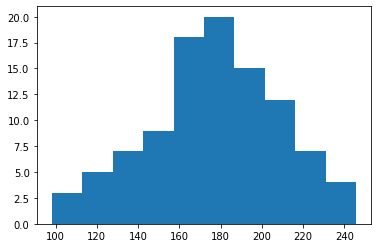

In [161]:
from scipy.stats import uniform
from scipy.stats import norm

sigma = uniform.rvs(0,50, 100)
mu = norm.rvs(178,np.sqrt(400), 100)

height = []
for i in range(100):
    height.append(norm.rvs(mu[i],sigma[i],1))

plt.hist(np.array(height))
plt.show()




We want now to integrate our data in the model, therefore we need to specify our likelihood:

$$p(y|\mu,\sigma^2) = N(y|\mu,\sigma^2).$$


At this point we have several ways of computing the posterior of our model, as we have seen during the last lesson. Unfortunately, the grid method tends to be very inefficient and inaccurate, and is therefore not the right choice in this case, since we start having a large number of observations. Also, we don't want to use the closed form that we derived for the Gaussian model, because we need to perform inference on $\sigma$ as well, and because we don't want to derive again all the maths each time we change the model.

For all these reason, we will use the *Laplace approximation*, as implemented in the toolbox *tools.py$. This function takes the as input the priors and the likelihood of our model, and gives us back an approximation of the posterior under the form of a Gaussian distribution fitting our posterior parameter space. So, the posterior Gaussian will have dimension equal to the number of parameters.

Let's see this machine in action:

In [51]:
# We specify a likelihood N(\mu, \sigma^2)

# initial values for the parameters mu and sigma2
mu = 183.
sigma = 2.

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = 178
prior_mu_sigma = 20
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]


In [41]:
solution = laplace_solution([mu,sigma], [], data1.height, likelihood, [prior_mu, prior_sigma])

      fun: 1227.9161145881894
 hess_inv: array([[3.56801509e+00, 1.80046586e-02],
       [1.80046586e-02, 3.05045181e-03]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 165
      nit: 26
     njev: 40
   status: 0
  success: True
        x: array([154.60702362,   7.73133283])


It seems that the machine worked correctly, let's explore in detail what we obtained. 
The solution is composed by the mean and the covariance of the posterior, in our case for the parameters $\mu$ and $\sigma$.
We can therefore sample from the posterior to explore our new model of height:

In [42]:
solution_mean = solution[0]
solution_sigma = solution[1]

posterior_samples = multivariate_normal.rvs(solution_mean, solution_sigma, size = 1000)


**Exercise.** Compute mean, standard deviation and 85% interval for the posterior parameters.

**Exercise.** Play around with the model, observe how the posterior changes in relation to the prior values.

**Exercise.** Play with priors and initialization to test the model, plot the results and compare them.

## Linear model

Now that we explored in detail the population height, we can finally start our studying on the relationship between weight and height.

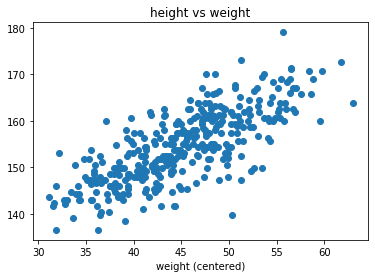

In [68]:
plt.scatter(data1.weight, data1.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

At this point we need to increase a bit the complexity of out Bayesian model, as we are now performing a *regression*.
In particular, we are interested in the relationship:

$$\mbox{height} = a + b * \mbox{weight},$$

and we would like to obtain posterior distributions for the regression coefficients $a$ and $b$. As in classical regression models, the variable $a$ is called *intercept*, and expresses the age we expect when the weight is 0, and $b$ is the *slope*, which indicates how much the height changes for a unit increase of weight.

To proceed with our Bayesian treatment, the trick here is to assume that our previous Gaussian model of height is indeed dependent on the variable weight through this linear relationship. In this case, the height of an individual $i$ is a sample from a Gaussian model:

$$\mbox{height}_i\sim N(\mu_i,\sigma^2),$$

whiel this time we impose that $\mu_i = a + b * \mbox{weight}_i$. Note that while we allow the mean $\mu_i$ to vary depending on the weight, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across subjects.  
To completely define our Bayesian model, we need to specify priors for all the parameters we want to analyze:

$$ p(a) = N(178, 1000),$$

$$ p(b) = N(0, 100),$$

$$ p(\sigma) = U(0, 50).$$

We code all these elements to run our black-box machine:

In [44]:
expr = 'height ~   weight'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

And we are finally ready to perform inference:

In [45]:
solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 1083.8791047602226
 hess_inv: array([[ 3.43833352e+00, -7.82682816e-02, -6.74372714e-02],
       [-7.82682816e-02,  1.80289114e-03,  1.39883270e-03],
       [-6.74372714e-02,  1.39883270e-03,  2.86392021e-02]])
      jac: array([1.52587891e-05, 5.79833984e-04, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 571
      nit: 50
     njev: 111
   status: 2
  success: False
        x: array([113.90341915,   0.90450553,   5.07186721])


As before, we can sample from our posterior to explore the distribution of our model parameters: 

In [57]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
a      113.900473  1.887767  111.234477  116.680655
b        0.904751  0.043315    0.843158    0.965439
sigma    5.060782  0.173599    4.816953    5.300344


We try to run the model again by centering the data, what is the difference in the posteriors? Can you explain this difference?

In [69]:
# Centering the data
mean_weight = np.mean(data1.weight)
data_center = data1
data_center.weight = data1.weight - mean_weight

# Fitting the model again
solution_regression_center = laplace_solution_regression(expr, data_center, likelihood, priors)

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


      fun: 1082.7486684880505
 hess_inv: array([[0.06943399, 0.06940371, 0.05815481],
       [0.06940371, 0.06987052, 0.05857496],
       [0.05815481, 0.05857496, 0.07405681]])
      jac: array([1.52587891e-05, 0.00000000e+00, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 116
      nit: 15
     njev: 23
   status: 2
  success: False
        x: array([154.60136758,   0.90501319,   5.07186788])


In [59]:
# Computing posterior samples
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_center, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_center, axis = 0)
# mean
post_mean = np.mean(posterior_samples_center, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      154.596828  0.037098  154.542190  154.649639
b        0.904969  0.037490    0.849549    0.957216
sigma    5.075129  0.169801    4.833210    5.318121


Once obtained the parameters, we can start exploring the model.
Let's plot the average prediction along the entire weight range:

[154.59682776   0.90496884   5.07512883]


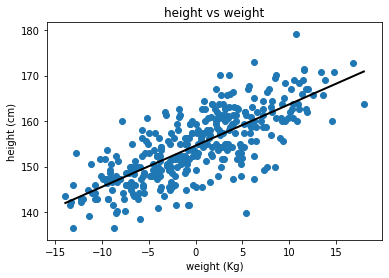

In [60]:
#plotting the average results 
print(post_mean)

x_range = np.linspace(min(data_center.weight), max(data_center.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

Now we can explore the variability of the prediction, this can be done by using the posterior samples for the coefficients that we computed before:

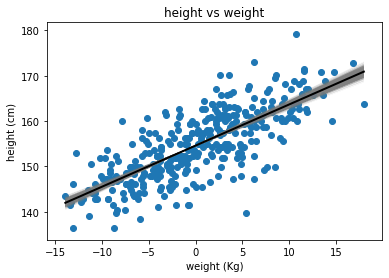

In [61]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_range
    plt.plot(x_range + mean_weight, prediction, lw = 0.05, color = 'grey')

plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')


plt.show()

By following the same modeling procedure, we can study how the uncertainty on the estimation of the coefficients varies with the different sample sizes: 

      fun: 71.32545922183961
 hess_inv: array([[ 1.10640117e+00,  9.43939578e-03, -2.88466505e-04],
       [ 9.43939578e-03,  1.80063602e-02,  6.37790158e-03],
       [-2.88466505e-04,  6.37790158e-03,  5.81541509e-01]])
      jac: array([0.00000000e+00, 7.62939453e-06, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 160
      nit: 24
     njev: 32
   status: 0
  success: True
        x: array([153.55884743,   0.86866286,   4.74646164])


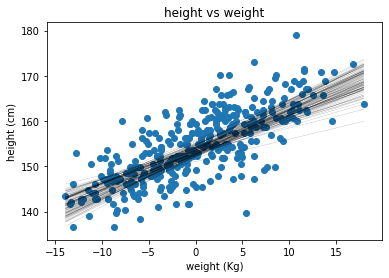

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 161.31066747857835
 hess_inv: array([[ 0.44385012, -0.00225006,  0.02119482],
       [-0.00225006,  0.00859417, -0.0022527 ],
       [ 0.02119482, -0.0022527 ,  0.23861194]])
      jac: array([-1.90734863e-06,  3.81469727e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 154
      nit: 26
     njev: 30
   status: 0
  success: True
        x: array([152.9254475 ,   0.88971198,   4.80911362])


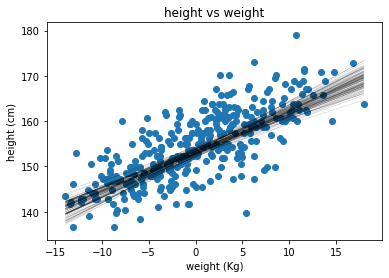

      fun: 478.3211606409031
 hess_inv: array([[ 1.97010209e-01, -2.25577992e-03, -7.01016307e-04],
       [-2.25577992e-03,  4.07764013e-03, -1.05918389e-04],
       [-7.01016307e-04, -1.05918389e-04,  9.67551274e-02]])
      jac: array([-3.81469727e-06, -7.62939453e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 22
     njev: 28
   status: 0
  success: True
        x: array([153.83813334,   0.90193026,   5.42665114])


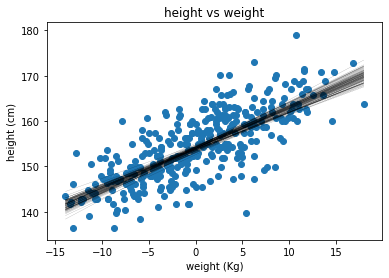

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 1076.6635796350186
 hess_inv: array([[ 0.03039004, -0.00138993, -0.02242795],
       [-0.00138993,  0.00210461, -0.00104291],
       [-0.02242795, -0.00104291,  0.02702069]])
      jac: array([0.00000000e+00, 4.57763672e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 129
      nit: 15
     njev: 25
   status: 2
  success: False
        x: array([154.62813519,   0.91056847,   5.07189243])


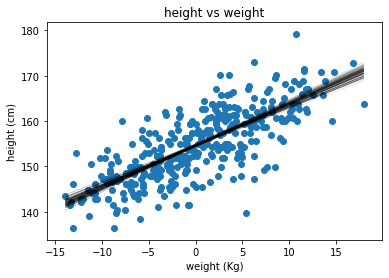

In [63]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Posterior uncertainty vs sample size

for N in [20,50,150,350]:
    
    # Selecting a subset of the data with sample size = N
    sub_data = data_center.head(N)
    # Fitting the model again
    R = laplace_solution_regression(expr, sub_data, likelihood, priors)

    # Computing posterior samples
    post_R = multivariate_normal.rvs(R[0], R[1], size = 1000)

    for i in range(100):
        prediction = post_R[i,0] + post_R[i,1] * x_range
        plt.plot(x_range, prediction, lw = 0.1, color = 'black')

    plt.scatter(data1.weight,data1.height)
    plt.title('height vs weight')
    plt.ylabel('height (cm)')
    plt.xlabel('weight (Kg)')


    plt.show()  


The model also allows us to quantify the uncertainty of the prediction for a single odata point.

**Exercise.** Predict the age distribution for a person of 50Kg.

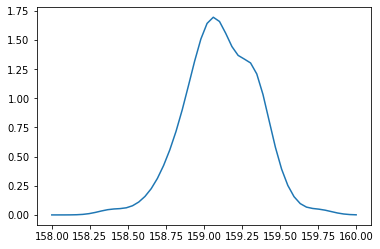

In [70]:
# Prediction for a person of 50Kg

x = 50
x_center = x - mean_weight
prediction = []
for i in range(100):
    prediction.append(posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_center)

data_density = gaussian_kde(prediction)
plt.plot(np.linspace(158,160), data_density(np.linspace(158,160)))
plt.show()

And we can repeat the exercise for the entire range of weights:

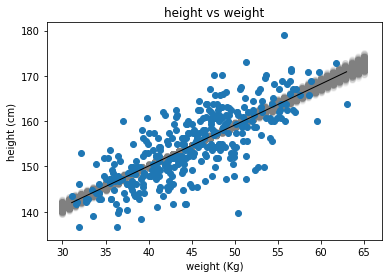

In [71]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight


prediction_range = []
N_s = len(posterior_samples_center[:,0])

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:,0] + posterior_samples_center[:,1] * x_)  

# Plotting the uncertainty
for i,x_ in enumerate(x_range_center):    
    plt.scatter(np.repeat(x_,N_s) + mean_weight, prediction_range[i], alpha = 0.05, color = 'grey')


#plotting the data
plt.scatter(data1.weight + mean_weight,data1.height)

# Plotting average prediction    
#avg_prediction = post_mean[0] + post_mean[1] * x_range_center
plt.plot(x_range + mean_weight, mean_prediction, lw = 1, color = 'black')

# Plotting +/- sigma theoretical interval
#plt.fill_between(x_range_center + mean_weight, mean_prediction - post_mean[2], mean_prediction + post_mean[2], alpha=0.1, color = 'green', linestyle='dashdot')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

plt.show()

So far we analyzed only the uncertainty related to the mean prediction, but we see that many data points fall clearly beyond the confidence interval.  
We can estimate the overall posterior uncertainty of the prediction, while accounting for the estimated regression noise. 
This requires to sample from the data posterior, accounting for the variability for both regression coefficients and modelled noise:

[]

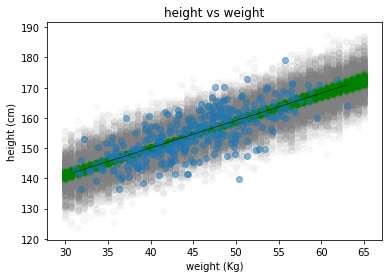

In [72]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range_noise.append(norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  posterior_samples_center[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data1.weight + mean_weight,data1.height, alpha = 0.5)
plt.plot(x_range + mean_weight, mean_prediction, lw = 0.5, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.plot()

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 

Which kind of model would you use for modeling this data?